In [1]:
# Data Preprocessing
import pandas as pd
import numpy as np
import os
import sys

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for text processing
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

#modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

# Accuracy Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to C:\Users\P V S
[nltk_data]     Karthik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\P V S
[nltk_data]     Karthik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
email = pd.read_csv('spam_ham_dataset.csv')

In [3]:
email.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
print(len(email['label_num'] == 0))
print(len(email['label_num']==1))

5171
5171


In [5]:
email['text'][1]

'Subject: hpl nom for january 9 , 2001\r\n( see attached file : hplnol 09 . xls )\r\n- hplnol 09 . xls'

In [6]:
email.drop('Unnamed: 0', axis =1, inplace = True)
email.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
email.shape

(5171, 3)

In [8]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [9]:
email.isna().sum()

label        0
text         0
label_num    0
dtype: int64

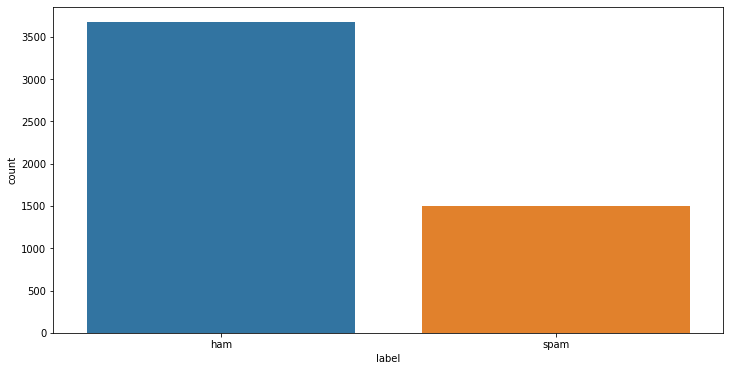

In [10]:
plt.figure(figsize = (12,6))
sns.countplot(data = email, x = 'label')

In [11]:
# let's see few examples of the data
for i in email.iterrows():
    print('class label :{}\nMail : \n{}\n\n'.format(i[1][0],i[1][1]))
    if i[0] == 6: break

class label :ham
Mail : 
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


class label :ham
Mail : 
Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls


class label :ham
Mail : 
Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .
on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 -

## Remove Stopwords from the Data

In [12]:
%%time
stop_words = set(stopwords.words('english')) 

email['text'] = email['text'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))

Wall time: 15.6 s


In [13]:
email.sample(10)

,label,text,label_num
4240,spam,Subject : food thoughts [ join - take free tou...,1
4042,ham,Subject : weekend oncall notes friday 1 / 19 /...,0
3768,spam,Subject : polar bear dilettantes defined 702 p...,1
976,spam,Subject : home loans & refinancing low rates !,1
4045,ham,"Subject : enron / hpl actuals july 25 , 2000 t...",0
875,spam,"Subject : account # 20367 tue , 28 jun 2005 11...",1
1627,ham,"Subject : enron actuals - dec . 26 , 2000 dec ...",0
2612,ham,Subject : : shut - meter 989842 need help one ...,0
895,ham,Subject : : / actual vols 5 / 22 / 01 agree ''...,0
2847,spam,Subject : save bundle meds ! font color = whit...,1


In [14]:
# dividing the data into features and target features....
X = email.loc[:, 'text']
y = email.loc[:, 'label_num']

In [15]:
X.head()

0    Subject : enron methanol ; meter # : 988291 fo...
1    Subject : hpl nom january 9 , 2001 ( see attac...
2    Subject : neon retreat ho ho ho , ' around won...
3    Subject : photoshop , windows , office . cheap...
4    Subject : : indian springs deal book teco pvr ...
Name: text, dtype: object

In [16]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: label_num, dtype: int64

## Splitting the data in 80:20 

In [17]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 11)

## Preprocess the text to build ML model

In [18]:
cVect = CountVectorizer()
cVect.fit(X_train)

CountVectorizer()

In [19]:
print('NO.of Tokens: ',len(cVect.vocabulary_.keys()))

NO.of Tokens:  44255


In [20]:
# document term vector (dtv)
dtv = cVect.transform(X_train)

In [21]:
type(dtv)

scipy.sparse.csr.csr_matrix

In [22]:
dtv = dtv.toarray()

In [23]:
print(f"Number of Observations: {dtv.shape[0]}\nTokens/Features: {dtv.shape[1]}")

Number of Observations: 4136
Tokens/Features: 44255


In [24]:
# Let's see an sample that has been preprocessed
dtv[1]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [25]:
lr = LogisticRegression(verbose=1)


In [26]:
grid={"C":[float(i) for i in range(1, 3)], "penalty":["l2"], "solver":[ 'lbfgs', 'liblinear']}
logreg_cv=GridSearchCV(lr, grid, cv=4)
logreg_cv.fit(dtv,y_train)

print("Tuned Hpyerparameters :",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Tuned Hpyerparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.97678916827853


In [27]:
%%time
lr = LogisticRegression(solver='liblinear', penalty ='l2' , C = 1.0)
lr.fit(dtv, y_train)

Wall time: 3.44 s


LogisticRegression(solver='liblinear')

In [28]:
# Preprocess the test data
test_dtv = cVect.transform(X_test)
test_dtv = test_dtv.toarray()
print(f"Number of Observations: {test_dtv.shape[0]}\nTokens/Features: {test_dtv.shape[1]}")

Number of Observations: 1035
Tokens/Features: 44255


In [29]:
%%time
pred = lr.predict(test_dtv)

Wall time: 395 ms


In [30]:
print('Accuracy: ', accuracy_score(y_test, pred) * 100)

Accuracy:  98.35748792270532


In [31]:
# 0 - Not Spam / Ham
# 1 - Spam 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       744
           1       0.95      0.99      0.97       291

    accuracy                           0.98      1035
   macro avg       0.97      0.99      0.98      1035
weighted avg       0.98      0.98      0.98      1035



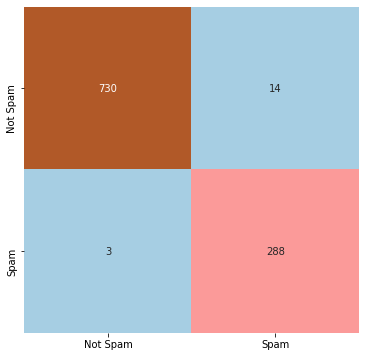

In [32]:
cmat = confusion_matrix(y_test, pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam']);

## Predict Class label for the unseen data i.e., Spam or Not Spam

In [33]:
# 'You won 1000$ prize money in lottery. Click here to avail'
def predict_class(lr):
    text = input('Enter Text(Subject of the mail): ')
    text = [' '.join([ word for word in word_tokenize(text)  if not word in stop_words])]
    t_dtv = cVect.transform(text).toarray()
    print('Predicted Class:', end = ' ')
    print('Spam' if lr.predict(t_dtv)[0] else 'Not Spam') 
    prob = lr.predict_proba(t_dtv)*100
    print(f"Not Spam: {prob[0][0]}%\nSpam: {prob[0][1]}%")
    plt.figure(figsize=(12, 6))
    sns.barplot(x =['Not Spam', 'Spam'] , y = [prob[0][0], prob[0][1]])
    plt.xlabel('Class')
    plt.ylabel('Probalility')
    plt.show()

Enter Text(Subject of the mail): Who is more active on Social Media? Men or Women
Predicted Class: Spam
Not Spam: 18.07482958230611%
Spam: 81.92517041769389%


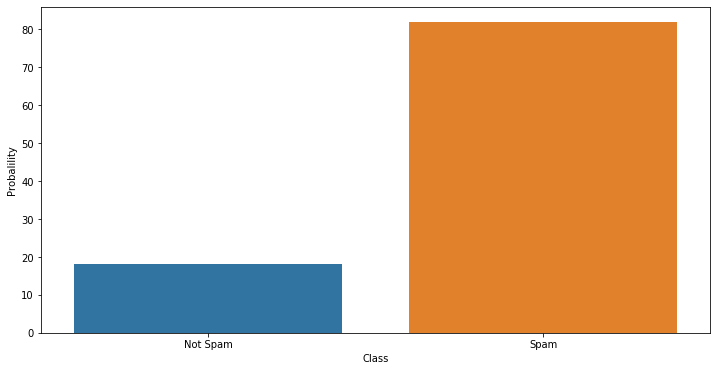

In [35]:
predict_class(lr)